In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

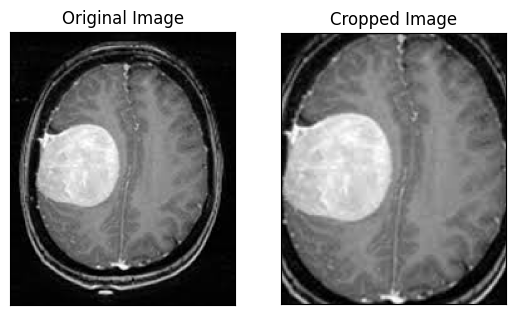

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
import os
from PIL import Image
import numpy as np

def load_data(dirs, img_size):
    """
    Load images from directories, resize them, and return NumPy arrays.
    
    Parameters:
        dirs (list of str): List of directory paths containing images.
        img_size (tuple): Size to resize images (width, height).
    
    Returns:
        X (np.ndarray): Array of image data.
        y (np.ndarray): Array of labels (0 or 1).
    """
    X = []
    y = []
    
    for label, directory in enumerate(dirs):
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(directory, filename)
                img = Image.open(filepath).resize(img_size)
                img_array = np.array(img, dtype=np.float32)  # Convert to float32
                X.append(img_array)
                y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    return X, y

# Define paths for 'yes' and 'no' directories
base_path = r'D:\DL\Brain-Tumor-Detection-master\augmented data'
augmented_yes = os.path.join(base_path, 'yes')
augmented_no = os.path.join(base_path, 'no')

# Constants for image dimensions
IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Load data from the directories
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

print(f"Loaded data shape: X={X.shape}, y={y.shape}")


Loaded data shape: X=(2065, 240, 240, 3), y=(2065,)


In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

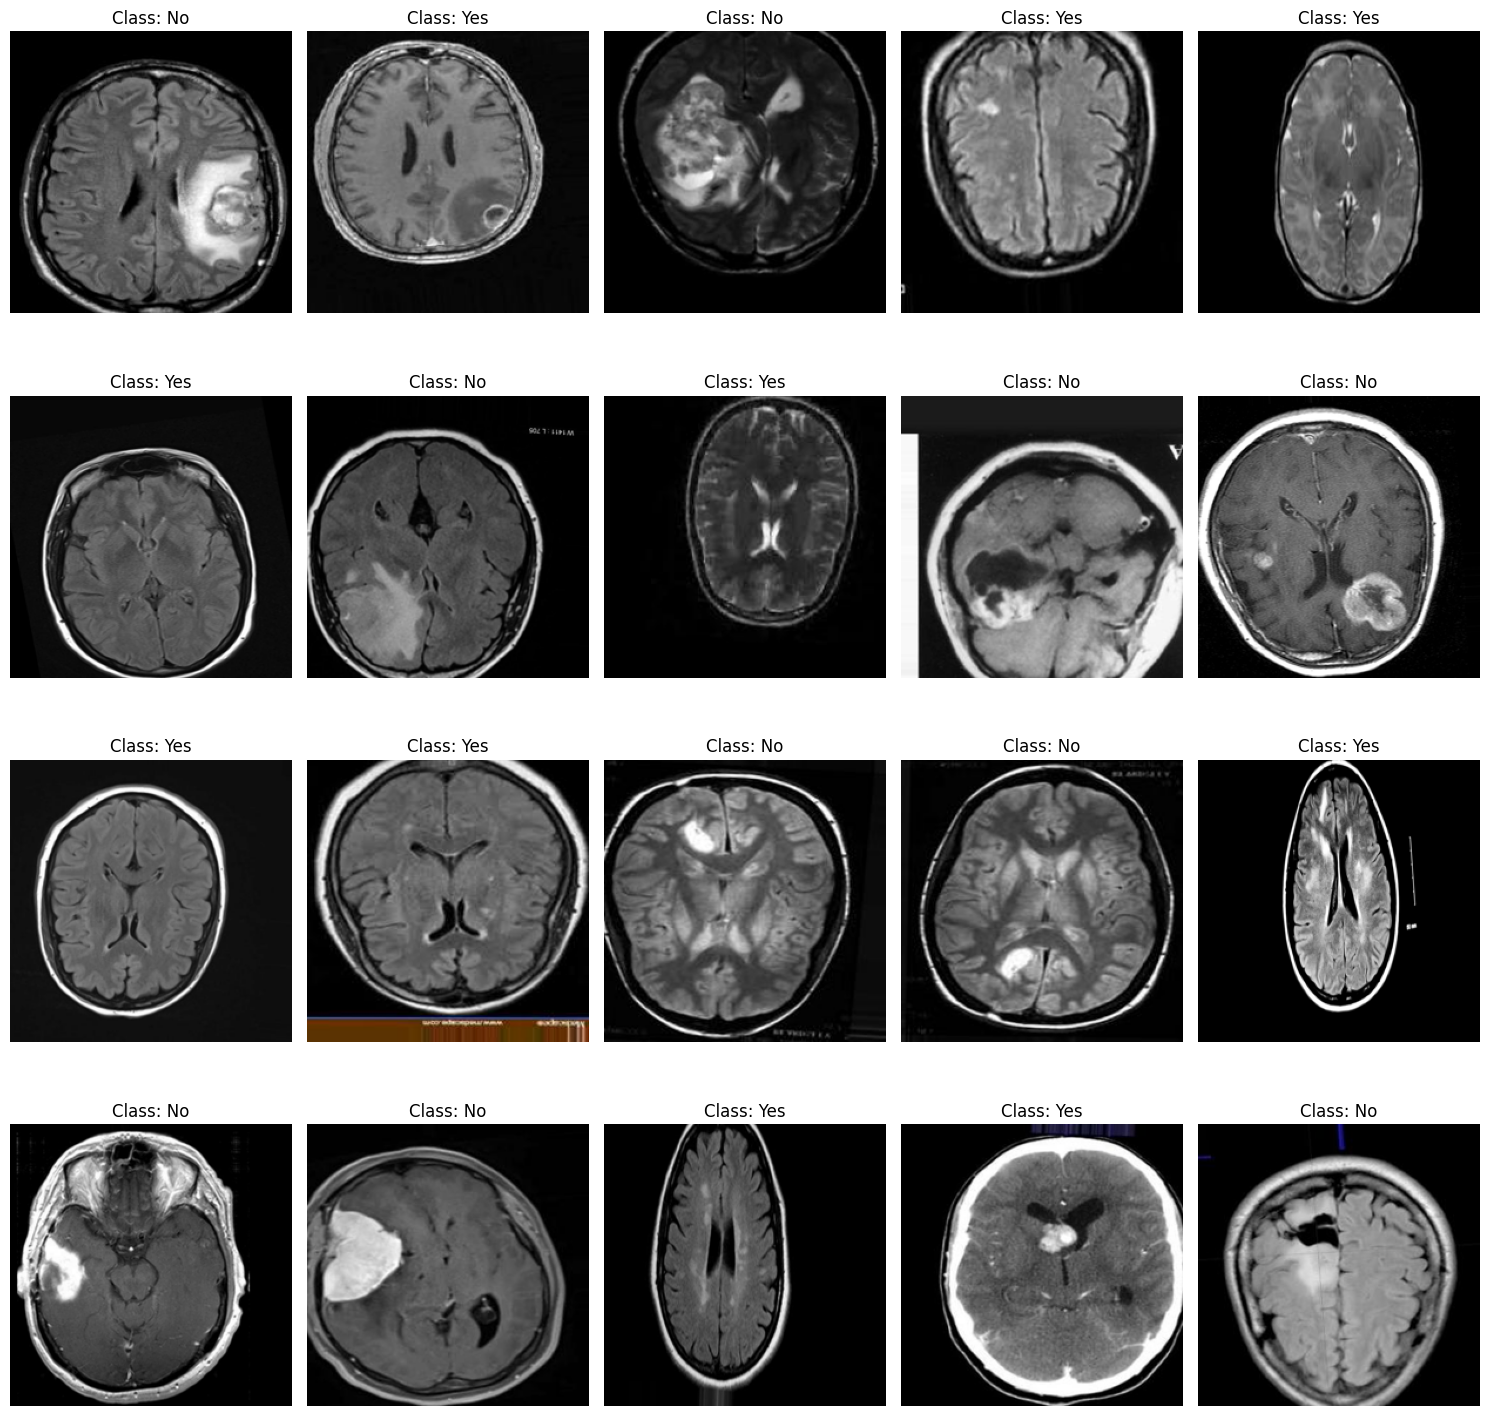

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(X, y, num_images=20):
    """
    Plot a grid of sample images from the dataset.
    
    Parameters:
        X (np.ndarray): Array of image data.
        y (np.ndarray): Array of labels (0 or 1).
        num_images (int): Number of images to display.
    """
    # Select a subset of images
    indices = np.random.choice(len(X), num_images, replace=False)
    sample_images = X[indices]
    sample_labels = y[indices]
    
    # Number of columns and rows in the plot grid
    columns_n = 5
    rows_n = num_images // columns_n
    
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(rows_n, columns_n, i + 1)
        plt.imshow(sample_images[i].astype(np.uint8))  # Convert to uint8 for display
        plt.title('Class: {}'.format('Yes' if sample_labels[i] == 1 else 'No'))
        plt.axis('off')  # Hide axis
        
    plt.tight_layout()
    plt.show()

# Assuming X and y have been defined and contain your image data and labels
# Plot sample images
plot_sample_images(X, y, num_images=20)


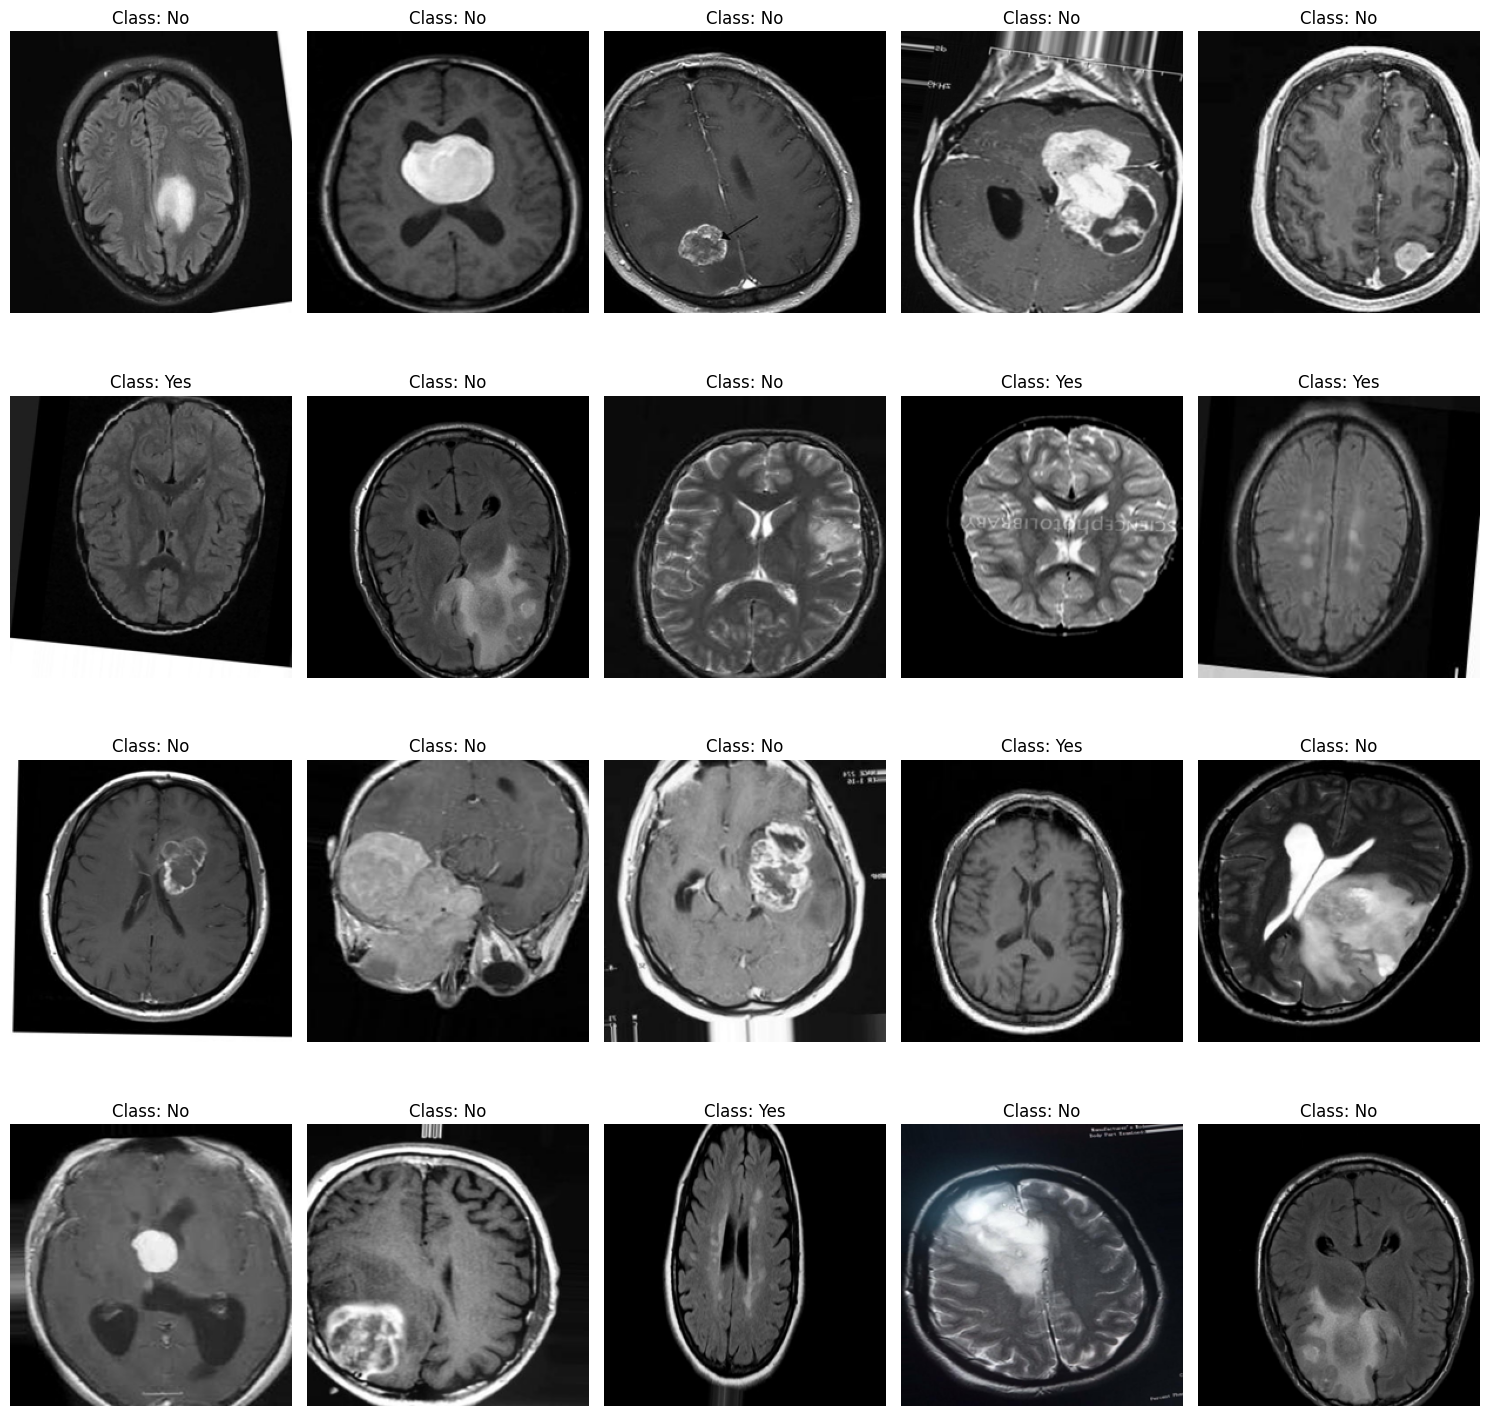

In [9]:
plot_sample_images(X, y)

In [10]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(X, y, test_size=0.2):
    """
    Splits data into training, validation, and test sets.
    
    Parameters:
        X (np.ndarray): Array of image data.
        y (np.ndarray): Array of labels (0 or 1).
        test_size (float): Proportion of the dataset to include in the test split.
        
    Returns:
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        X_test, y_test: Test data and labels.
    """
    # Split data into training and test+validation sets
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Split test+validation set into validation and test sets
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Assuming X and y have been defined and contain your image data and labels
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data shape: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(1445, 240, 240, 3), y_train=(1445,)
Validation data shape: X_val=(310, 240, 240, 3), y_val=(310,)
Test data shape: X_test=(310, 240, 240, 3), y_test=(310,)


In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445,)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310,)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310,)


In [15]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [16]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [17]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D

def build_model(input_shape):
    """
    Builds a CNN model with the specified input shape.
    
    Parameters:
        input_shape (tuple): Shape of the input tensor (height, width, channels).
        
    Returns:
        model (tf.keras.Model): A Keras Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape
    X_input = Input(shape=input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)

    # Convolutional Layer: applies filters to the input
    X = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)

    # Additional Convolutional Layers
    X = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    
    # Flatten the output of the convolutional layers
    X = Flatten()(X)
    
    # Fully Connected Layer
    X = Dense(units=128, activation='relu')(X)
    X = Dropout(0.5)(X)  # Dropout layer for regularization
    
    # Output Layer
    X = Dense(units=1, activation='sigmoid')(X)

    # Create the model instance
    model = Model(inputs=X_input, outputs=X)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define the input shape
IMG_HEIGHT, IMG_WIDTH = 240, 240
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Build the model
model = build_model(IMG_SHAPE)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 222784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    28,516,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,536,001 (108.86 MB)

 Trainable params: 28,536,001 (108.86 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 119, 119, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 222784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    28,516,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,536,001 (108.86 MB)

 Trainable params: 28,536,001 (108.86 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
import time
from tensorflow.keras.callbacks import TensorBoard
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [23]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for saving the model
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',  # Monitoring validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Ensure the 'models' directory exists
if not os.path.exists('models'):
    os.makedirs('models')

# Example of how to fit the model with ModelCheckpoint callback
# Assuming `model`, `X_train`, `y_train`, `X_val`, and `y_val` are defined

model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6034 - loss: 89.5869
Epoch 1: val_accuracy improved from -inf to 0.69032, saving model to models/cnn-parameters-improvement-01-0.69.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - accuracy: 0.6038 - loss: 88.4270 - val_accuracy: 0.6903 - val_loss: 0.6068
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7432 - loss: 0.5319
Epoch 2: val_accuracy did not improve from 0.69032
46/46 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.7431 - loss: 0.5323 - val_accuracy: 0.6387 - val_loss: 0.6490
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8173 - loss: 0.3978
Epoch 3: val_accuracy did not improve from 0.69032
46/46 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.8171 - loss: 0.3981 - val_accuracy: 0.6419 - val_loss: 0.6919
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.8562 - loss: 0.3481 
Epoch 4: val_accuracy improved from 0.69032 to 0.70968, saving model to models/cnn-parameters-imp

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9526 - loss: 0.1295
Epoch 1: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.9527 - loss: 0.1294 - val_accuracy: 0.7000 - val_loss: 1.5531
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9735 - loss: 0.1060
Epoch 2: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.9735 - loss: 0.1059 - val_accuracy: 0.6871 - val_loss: 1.2012
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9799 - loss: 0.0717
Epoch 3: val_accuracy did not improve from 0.73226
46/46 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.9799 - loss: 0.0715 - val_accuracy: 0.6903 - val_loss: 1.7427
Elapsed time: 0:8:47.6


In [25]:
history = model.history.history

In [26]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [33]:
import matplotlib.pyplot as plt

def plot_metrics(history_dict):
    """
    Plots training and validation loss and accuracy metrics from the training history dictionary.
    
    Parameters:
        history_dict (dict): The training history dictionary returned by model.fit.
    """
    # Extract metrics
    train_loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])
    train_acc = history_dict.get('accuracy', [])
    val_acc = history_dict.get('val_accuracy', [])
    
    # Plot Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



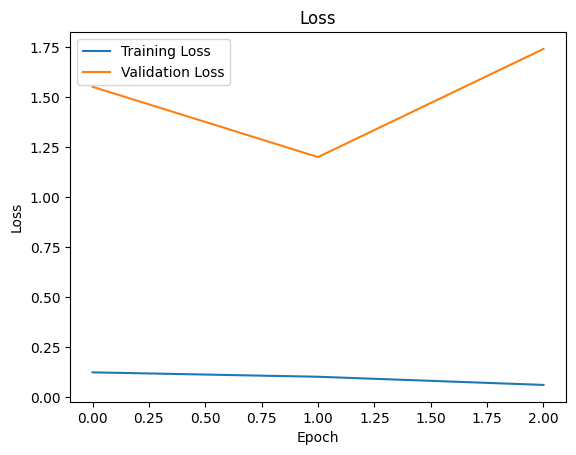

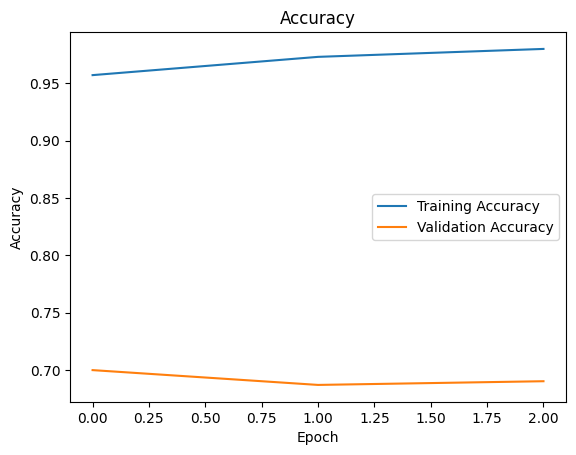

In [32]:
plot_metrics(history) 

In [40]:
best_model.metrics_names

['loss', 'compile_metrics']

In [41]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 586ms/step - accuracy: 0.6963 - loss: 0.8498


In [42]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.7859098315238953
Test Accuracy = 0.7225806713104248


In [43]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 601ms/step


In [45]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.6861313868613139


In [46]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 782ms/step


In [47]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.7296416938110749


In [48]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [49]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 47.45762711864407%, number of pos examples: 980
Percentage of negative examples: 52.54237288135593%, number of neg examples: 1085


In [50]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 47.05882352941177%, number of pos examples: 680
Percentage of negative examples: 52.94117647058823%, number of neg examples: 765
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.96774193548387%, number of pos examples: 158
Percentage of negative examples: 49.03225806451613%, number of neg examples: 152
Testing Data:
Number of examples: 310
Percentage of positive examples: 45.806451612903224%, number of pos examples: 142
Percentage of negative examples: 54.193548387096776%, number of neg examples: 168
